In [1]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error as rmse

## Loading data

In [2]:
DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_gust_max_daily,wind_speed_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro
time,,,,,,,,,,,,,,,,
2023-12-20,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,252.000000,12.2,2.541667,0.4,4.0,349.0,111.0,4448.18
2023-12-21,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,254.666667,22.5,5.329167,19.9,159.0,270.0,29.5,5602.14
2023-12-22,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,293.416667,19.1,5.020833,0.6,3.0,749.0,294.5,6636.60
2023-12-23,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,264.000000,10.5,2.379167,0.8,4.0,589.0,247.0,5809.15
2023-12-24,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,136.500000,6.6,1.500000,5.0,38.0,9.0,0.0,5197.78


In [3]:
# Check for missing values
df.isnull().sum()

temp_min_daily             0
temp_max_daily             0
temp_mean_daily            0
temp_grass_mean_daily      0
temp_soil_min_daily        0
temp_soil_max_daily        0
temp_soil_mean_daily       0
humidity_daily             0
wind_direction_daily       0
wind_gust_max_daily        0
wind_speed_daily           0
precip_total_daily         0
precip_duration_daily      0
radiation_global_daily     0
sunshine_duration_daily    0
KarupBro                   0
dtype: int64

<Figure size 1200x1200 with 0 Axes>

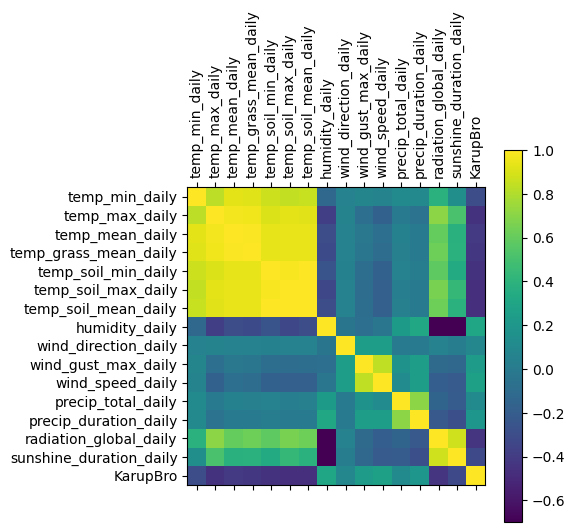

In [4]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 12))
plt.matshow(corr, fignum=2)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

## Filtering data to simple model

In [5]:
df_simple = df[["temp_mean_daily", "precip_total_daily", "KarupBro"]]
df_simple.head()

,temp_mean_daily,precip_total_daily,KarupBro
time,,,
2002-01-01,1.250000,2.2,1829.75
2002-01-02,-0.837500,0.0,7279.46
2002-01-03,-5.166667,0.0,5261.85
2002-01-04,-6.025000,0.0,2951.97
2002-01-05,-3.466667,0.1,1868.53


<Axes: xlabel='time'>

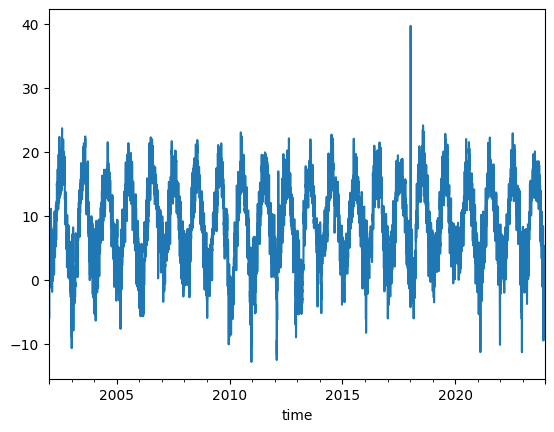

In [6]:
temp = df['temp_mean_daily']
temp.plot()

In [7]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

<Axes: xlabel='time'>

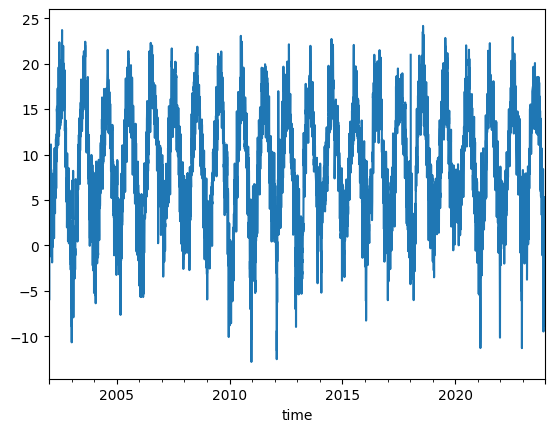

In [8]:
temp.plot()

<Axes: xlabel='time'>

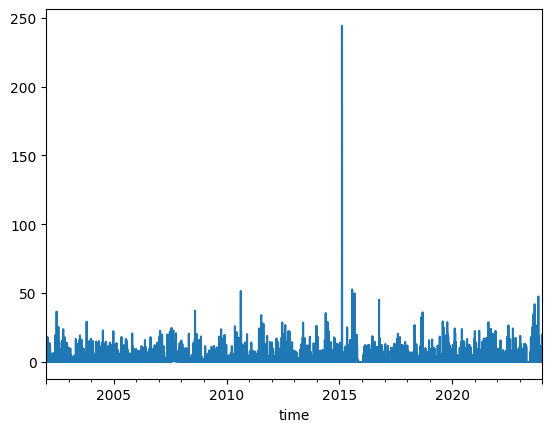

In [9]:
rain = df['precip_total_daily']
rain.plot()

In [10]:
import numpy as np

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

<Axes: xlabel='time'>

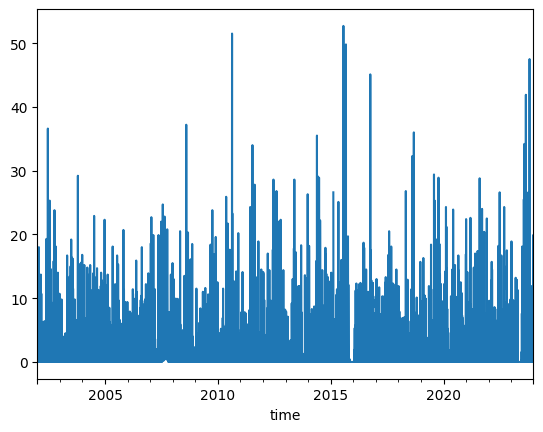

In [11]:
rain.plot()

<Axes: xlabel='time'>

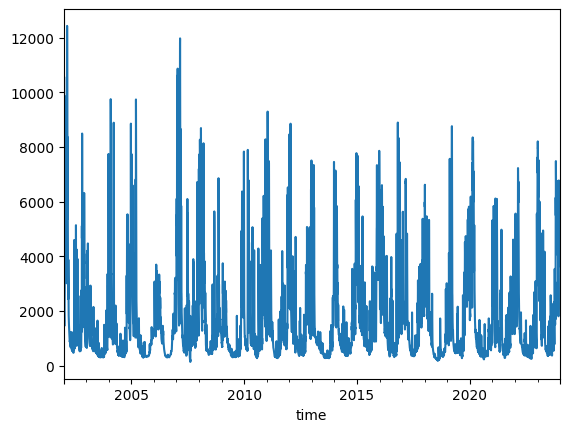

In [12]:
inflow = df['KarupBro']
inflow.plot()

## Multi-variable

In [13]:
inflow_df = pd.DataFrame({'Inflow':inflow})
inflow_df['Seconds'] = inflow_df.index.map(pd.Timestamp.timestamp)
inflow_df

,Inflow,Seconds
time,,
2002-01-01,1829.75,1.009843e+09
2002-01-02,7279.46,1.009930e+09
2002-01-03,5261.85,1.010016e+09
2002-01-04,2951.97,1.010102e+09
2002-01-05,1868.53,1.010189e+09
...,...,...
2023-12-20,4448.18,1.703030e+09
2023-12-21,5602.14,1.703117e+09
2023-12-22,6636.60,1.703203e+09


In [14]:
day = 24*60*60
year = (365.2425)*day

inflow_df['Rain'] = df['precip_total_daily']
inflow_df['Temp'] = df['temp_mean_daily']
inflow_df['Year sin'] = np.sin(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df['Year cos'] = np.cos(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df = inflow_df.drop('Seconds', axis=1)
inflow_df

,Inflow,Rain,Temp,Year sin,Year cos
time,,,,,
2002-01-01,1829.75,2.2,1.250000,0.004129,0.999991
2002-01-02,7279.46,0.0,-0.837500,0.021330,0.999772
2002-01-03,5261.85,0.0,-5.166667,0.038525,0.999258
2002-01-04,2951.97,0.0,-6.025000,0.055708,0.998447
2002-01-05,1868.53,0.1,-3.466667,0.072875,0.997341
...,...,...,...,...,...
2023-12-20,4448.18,0.4,3.141667,-0.206570,0.978432
2023-12-21,5602.14,19.9,5.316667,-0.189708,0.981841
2023-12-22,6636.60,0.6,2.395833,-0.172790,0.984959


In [17]:
import numpy as np
import pandas as pd
import padasip as pa

# For one-day-ahead forecasting without a window:
# For each time t (from 1 to n-1), we use:
#   - A constant term (bias)
#   - The inflow value from the previous day: df['Inflow'][t-1]
#   - Temperature and Precipitation for the forecast day (day t)
# And we predict the inflow for day t.
X, y = [], []
for t in range(1, len(inflow_df)):
    x_input = np.array([
        1.0,                      # Constant term for bias
        inflow_df['Inflow'].iloc[t-1],   # Previous day's inflow
        inflow_df['Temp'].iloc[t],       # Temperature for forecast day
        inflow_df['Rain'].iloc[t]  # Precipitation for forecast day
    ])
    X.append(x_input)
    y.append(inflow_df['Inflow'].iloc[t])
X = np.array(X)
y = np.array(y)

# Initialize the RLS filter
# n_features = 4 (constant, previous inflow, temperature, precipitation)
rls_filter = pa.filters.FilterRLS(n=X.shape[1], mu=0.99, w="zeros")

# Online forecasting: predict and then update the filter with the new observation
predictions = []
for xi, yi in zip(X, y):
    y_pred = rls_filter.predict(xi)
    predictions.append(y_pred)
    rls_filter.adapt(yi, xi)

# Create a DataFrame to compare predictions with actual values
results_df = pd.DataFrame({
    'Prediction': predictions,
    'Actual': y
})
print(results_df.tail())

       Prediction   Actual
8022  3838.521302  4448.18
8023  4896.136452  5602.14
8024  5434.151173  6636.60
8025  6469.848861  5809.15
8026  5788.405112  5197.78


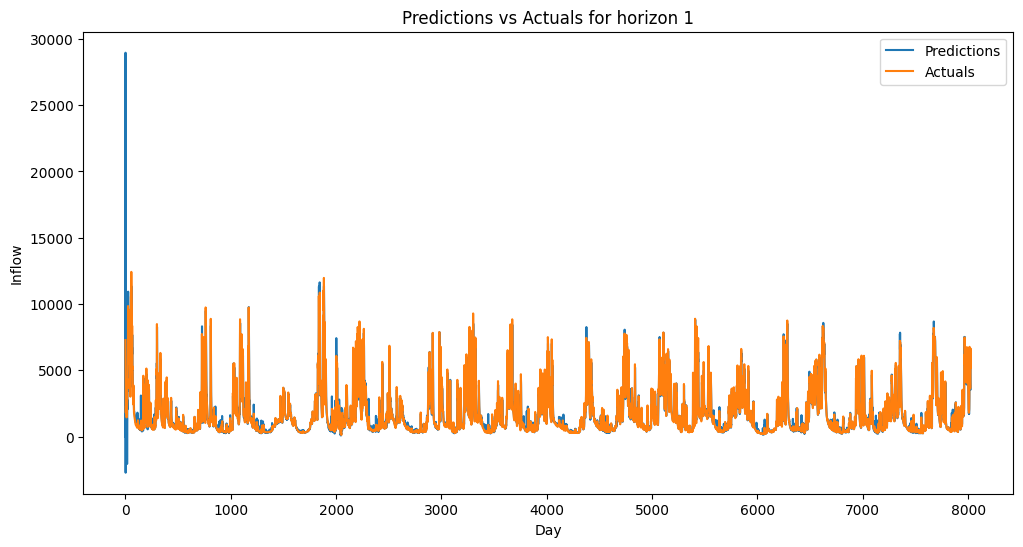

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(results_df["Prediction"], label='Predictions')
plt.plot(results_df["Actual"], label='Actuals')
plt.xlabel('Day')
plt.ylabel('Inflow')
plt.title("Predictions vs Actuals for horizon 1")
plt.legend()
plt.show()